<a href="https://colab.research.google.com/github/seanita/deep_learning_with_python/blob/master/predicting_housing_prices_boston.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [0]:
print(train_data.shape)
print(test_data.shape)

'''
Sort training housing prices and get price of least and most expensive home.
Below returns value of 5.0 and 50.0

train_targets.sort()
print(train_targets[0], train_targets[-1])
print(train_data.shape[1])

'''

(404, 13)
(102, 13)


'\n# Sort training housing prices and get price of least and most expensive home.\nBelow returns value of 5.0 and 50.0\n\ntrain_targets.sort()\nprint(train_targets[0], train_targets[-1])\nprint(train_data.shape[1])\n\n'

Normalize features in train and test data

In [0]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

Build network

In [0]:
from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1], )))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))  # no activation for final layer is typical for scalar regression problems, when predicting a single continuous value
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

Splitting data into K=4 partitions to evaluate model and obtain the average of K validation scores

In [0]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

Prepping validation dat for partitioning

In [0]:
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  
  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
       train_data[(i + 1) * num_val_samples:]],
       axis=0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
       train_targets[(i + 1) * num_val_samples:]],
       axis=0)
  
  model = build_model()
  model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

processing fold # 0








processing fold # 1
processing fold # 2
processing fold # 3


In [31]:
print(all_scores)
np.mean(all_scores)

[11.709083056685948, 6.41311251290954, 5.8385151683694065, 18.03368067977452]


10.498597854434854

For cross validation, it looks like we're off by an average of approx $10,500, which is a lot. Let's train the network a bit longer, increasing epochs to 500. We'll keep a log of how model performs per epoch and save the validation score.

In [29]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  
  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
       train_data[(i + 1) * num_val_samples:]],
       axis=0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
       train_targets[(i + 1) * num_val_samples:]],
       axis=0)
  
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, 
                      validation_data=(val_data, val_targets),
                      epochs=num_epochs, batch_size=1, verbose=0)
  mae_history = history.history['val_mean_absolute_error']  
  all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [32]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
# print(average_mae_history)

[9.37095061387166, 9.171390073134166, 9.48618731640353, 8.669386570996577, 8.776085563225323, 9.05913796991405, 9.42179579309898, 9.671591739843386, 8.976342434930329, 9.075788710377005, 9.933975576174142, 9.050595304753521, 8.534020867678198, 9.081228593788524, 9.175132616911785, 9.220096382764307, 9.366524434325719, 9.659361544221936, 9.123974417695905, 8.838228117121329, 8.58542283218686, 8.565899853659149, 9.172601607766483, 9.100773263685774, 9.330913208498814, 8.687521485999078, 10.009826372165492, 9.187376912277523, 9.585890576390938, 8.75896707619771, 9.38697069234187, 9.60095485602275, 9.602063457564551, 8.875665043840314, 9.300626872789742, 8.637370550986564, 8.922075047351345, 9.199200514519568, 9.25553034791852, 9.488527956575451, 9.08828829774762, 9.673117484196577, 9.740435342977543, 9.741430313280313, 8.758409686607889, 9.609368817641004, 9.812455793418506, 8.714080163747958, 9.45261546880892, 9.480823025845066, 9.173391991322584, 8.576079614091627, 9.800972844114398, 9.

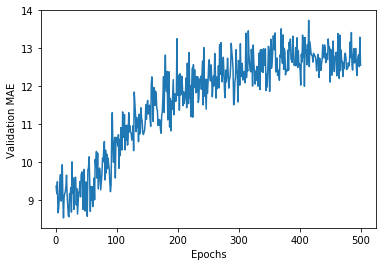

In [35]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

In [34]:
model = build_model()
model.fit(train_data, train_targets,
         epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

test_mae_score

102/102 [==============================] - 0s 2ms/step


5.90456802704755

Smooth out curve by remove first 10 data points and replace each point with an exponential moving adverage of previous points.

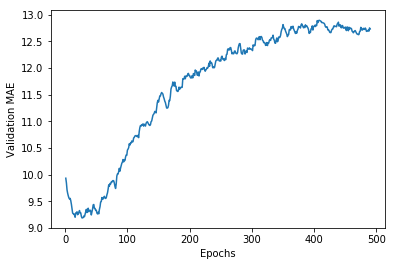

In [37]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

In [39]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print(test_mae_score)

102/102 [==============================] - 0s 3ms/step
5.717806928298053


We are still off by $5,717.